Data loaded. Shape: (11721, 100)
✅ Régression Ridge terminée
📉 MSE : 0.2209
📈 R² : 0.8913
🔢 Variables utilisées : (11721, 229)


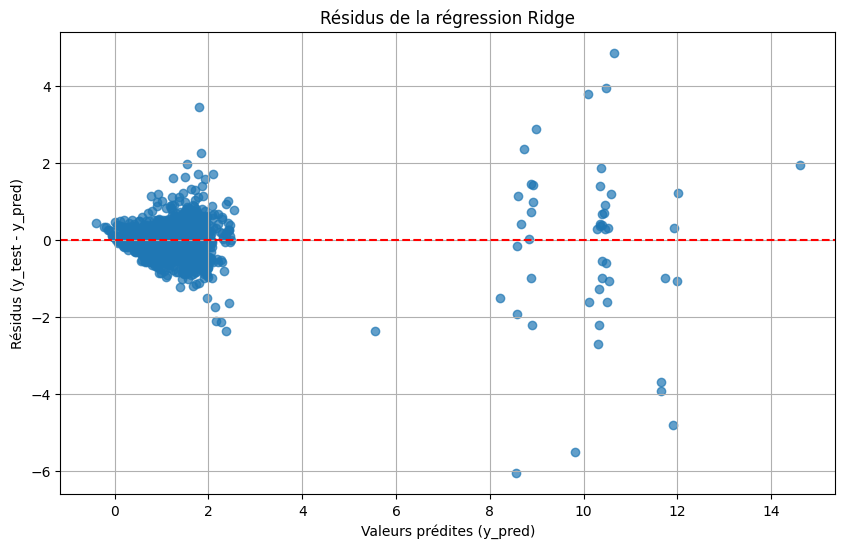

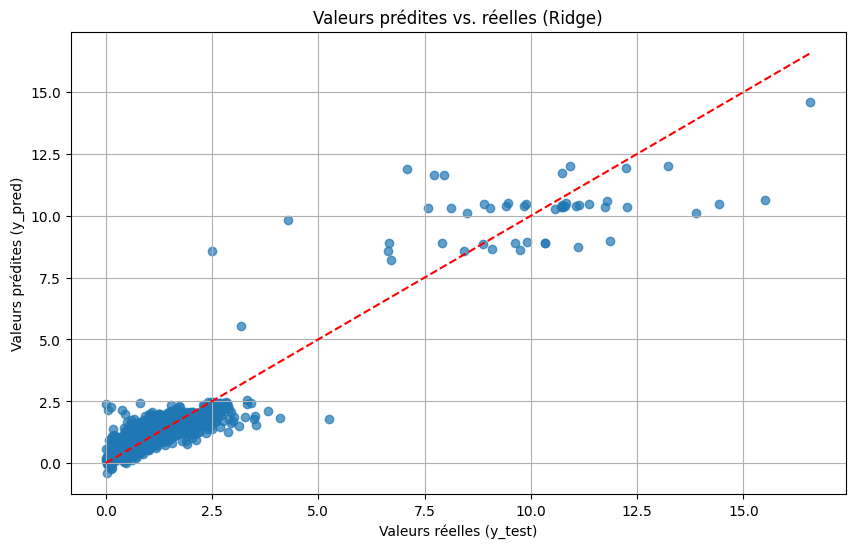

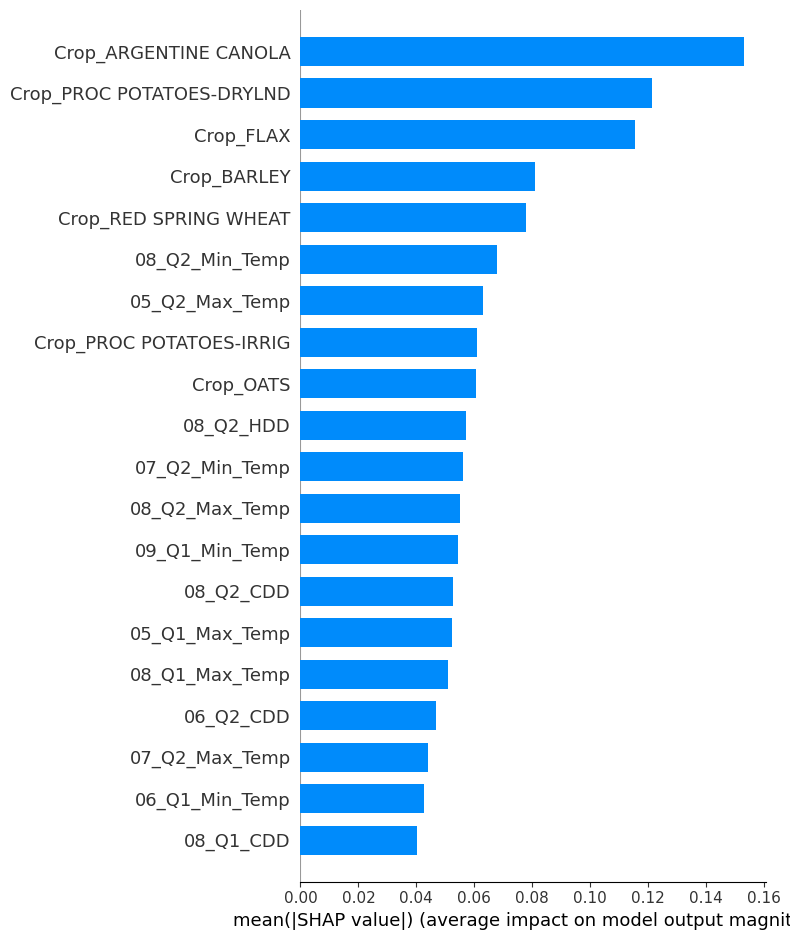

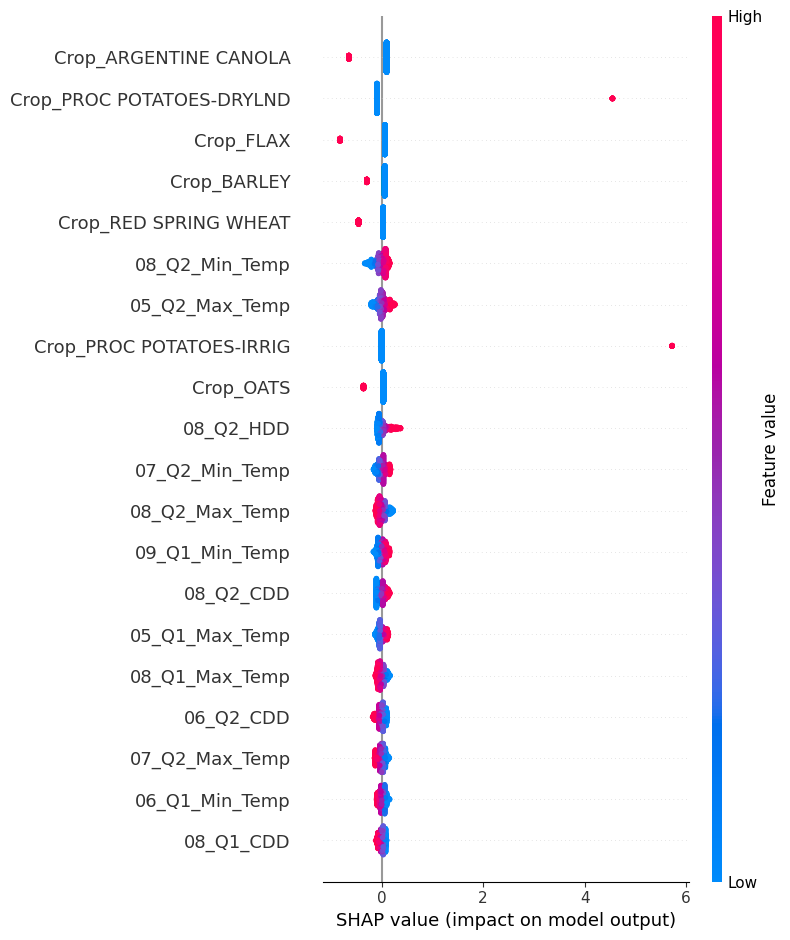

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score

# === 1. Load data ===
df = pd.read_csv("./prepared/yields_weather_by_crop.csv")
print("Data loaded. Shape:", df.shape)

# === 2. Preprocessing ===
df["Municipality"] = df["Municipality"].str.upper()
df["Crop"] = df["Crop"].str.upper()
df = pd.get_dummies(df, columns=["Crop","Municipality"], drop_first=True)  # One-hot encode Crop
df = df.drop(columns=["Year"])  # Drop non-numeric cols

# === 3. Prepare features and target ===
X = df.drop(columns=["Mean_Yield"])
y = df["Mean_Yield"]

# Drop columns with too many NaNs and rows with any remaining NaNs
col_thresh = int(0.3 * len(X))
X = X.dropna(axis=1, thresh=(len(X) - col_thresh))
X = X.dropna()
y = y.loc[X.index]

# === 4. Standardize features and transform target ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()#QuantileTransformer(output_distribution="normal", random_state=42)

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# === 5. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=True
)

# === 6. Ridge Regression ===
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred_scaled = ridge.predict(X_test)

# === 7. Inverse transform predictions ===
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# === 8. Evaluation ===
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)

print("✅ Régression Ridge terminée")
print(f"📉 MSE : {mse:.4f}")
print(f"📈 R² : {r2:.4f}")
print(f"🔢 Variables utilisées : {X.shape[1]}")

# === 9. Residual plot ===
residuals = y_test_orig - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Valeurs prédites (y_pred)")
plt.ylabel("Résidus (y_test - y_pred)")
plt.title("Résidus de la régression Ridge")
plt.grid(True)
plt.show()

# === 10. Predicted vs Actual plot ===
plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, y_pred, alpha=0.7)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("Valeurs réelles (y_test)")
plt.ylabel("Valeurs prédites (y_pred)")
plt.title("Valeurs prédites vs. réelles (Ridge)")
plt.grid(True)
plt.show()

# === 11. SHAP Explanation ===
X_test_df = pd.DataFrame(X_test, columns=X.columns)
explainer = shap.Explainer(ridge, X_train, feature_names=X.columns)
shap_values = explainer(X_test_df)

# Summary plot (bar and beeswarm)
shap.summary_plot(shap_values, X_test_df, plot_type="bar")
shap.summary_plot(shap_values, X_test_df)


